In [87]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [88]:
def load_arrs(id, data_dir):
    '''
    Retorno:
        num_active, num_created, time
    '''
    num_active = np.load(f"{data_dir}/num_active_{id}.npy")
    num_created = np.load(f"{data_dir}/num_created_{id}.npy")
    time = np.load(f"{data_dir}/time_{id}.npy")

    return num_active, num_created, time

def get_conv_arr(arr, kernel_size):
    num_points = arr.size - kernel_size
    new_arr = np.zeros(num_points, dtype=arr.dtype)
    for i in range(num_points):
        new_arr[i] = arr[i:i+kernel_size].sum()
    
    # start_id = 0
    # end_id = start_id + kernel_size
    # while end_id <= arr.size:
    #     new_arr[i] = arr[i:i+kernel_size].sum()

    return new_arr

def get_mean_arr(arr, kernel_size):
    new_arr = []
    start_id = 0
    end_id = start_id + kernel_size
    while end_id <= arr.size:
        new_arr.append(arr[start_id:end_id].sum()/kernel_size)
        start_id = end_id
        end_id += kernel_size

    return np.array(new_arr)


In [107]:
data_dir = "data/data2"
img_dir = "data/images/data2"

kernel_time = 50

dt = 0.01
kernel_size = int(kernel_time/dt)

create_rate_arr = []
mean_std = {
    "active": ([], []),
    "created": ([], []),
}

flux_range = np.load(f"{data_dir}/flux.npy")
# for id in range(flux_range.size):
for id in range(flux_range.size):
    num_active, num_created, time = load_arrs(id, data_dir)
    
    values = {
        "active": num_active,
        # "created": get_conv_arr(num_created, kernel_size)/kernel_time,
        "created": get_mean_arr(num_created, kernel_size)/dt,
    }
    for name in mean_std.keys():
        mean_std[name][0].append(values[name].mean())
        mean_std[name][1].append(values[name].std())

    rate = num_created.sum()/(time[-1] - time[0])
    create_rate_arr.append(rate)    

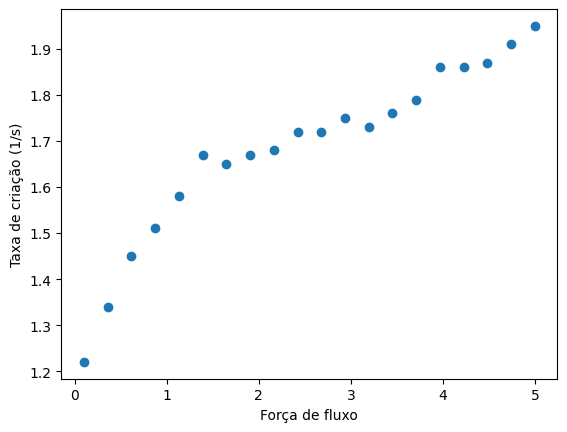

In [108]:
plt.scatter(flux_range, create_rate_arr)

plt.xlabel("Força de fluxo")
plt.ylabel("Taxa de criação (1/s)")

plt.savefig(os.path.join(img_dir, "creation_rate.png"))

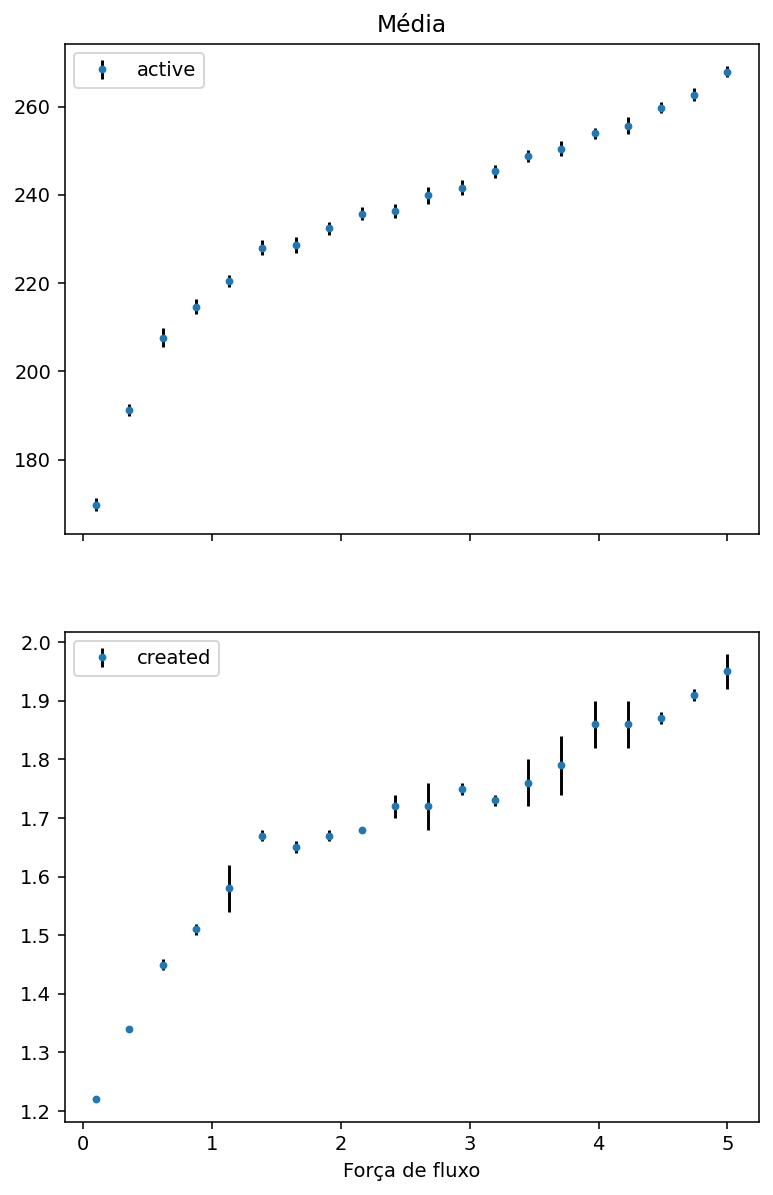

In [109]:
fig, ax = plt.subplots(2, sharex=True)
fig.set_dpi(140)
fig.set_figheight(10)


name = "active"
ax[0].errorbar(flux_range, mean_std[name][0], mean_std[name][1], fmt=".", ecolor="black", label=name)

name = "created"
ax[1].errorbar(flux_range, mean_std[name][0], mean_std[name][1], fmt=".", ecolor="black", label=name)

ax[0].set_title("Média")


for i in range(2):
    ax[i].legend()

ax[1].set_xlabel("Força de fluxo")

ax[0].set_ylabel("Nº de anéis")
ax[1].set_ylabel("Taxa de criação (Por unidade de tempo)")

fig.savefig(os.path.join(img_dir, "creation_rate2.png"))

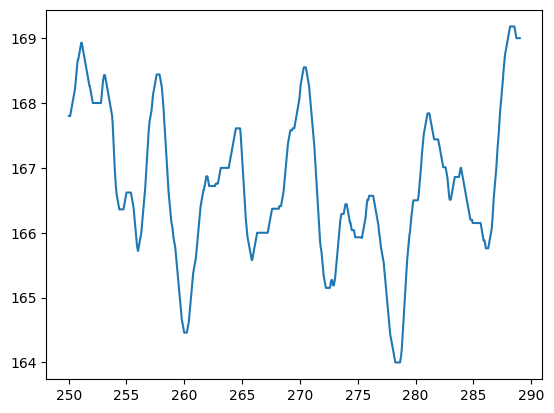

In [63]:
num_active, num_created, time = load_arrs(0, "data/data1")

dt =0.01
t=1
ks = int(t/dt)

mean_created = get_conv_arr(num_active, ks)/ks

plt.plot(time[:mean_created.size], mean_created)

# plt.hist(get_mean_arr(num_created, int(t/dt)), bins=20)
# plt.figure()
# plt.hist(num_active, bins=20)